# Predicting Product Success When Review Data Is Available
## _**Using XGBoost to Predict Whether Sales will Exceed the "Hit" Threshold**_

---


# Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Train](#Train)
1. [Real-time Inference](#Real-time)
1. [Evaluation](#Evaluation)
1. [Batch Inference](#Batch)
1. [Clean Up](#CleanUp)

---

# Background

Word of mouth in the form of user reviews, critic reviews, social media comments, etc. often can provide insights about whether a product ultimately will be a success. In the video game industry in particular, reviews and ratings can have a large impact on a game's success. However, not all games with bad reviews fail, and not all games with good reviews turn out to be hits. To predict hit games, machine learning algorithms potentially can take advantage of various relevant data attributes in addition to reviews.  

For this notebook, we will work with the data set Video Game Sales with Ratings. This [Metacritic](http://www.metacritic.com/browse/games/release-date/available) data includes attributes for user reviews as well as critic reviews, sales, ESRB ratings, among others. Both user reviews and critic reviews are in the form of ratings scores, on a scale of 0 to 10 or 0 to 100. Although this is convenient, a significant issue with the data set is that it is relatively small.  

Dealing with a small data set such as this one is a common problem in machine learning. This problem often is compounded by imbalances between the classes in the small data set. In such situations, using an ensemble learner can be a good choice.  This notebook will focus on using XGBoost, a popular ensemble learner, to build a classifier to determine whether a game will be a hit. 



---
# Setup
![Over of the workshop](img/overview2.png)

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- Import all the necessary libraries
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [1]:
# import the necessary libraries
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt   
from IPython.display import Image                 
from IPython.display import display                 
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json
import boto3
import os


In [2]:
# need Sagemaker execution role
import sagemaker
role = sagemaker.get_execution_role()
role

'arn:aws:iam::406078665760:role/service-role/AmazonSageMaker-ExecutionRole-20210607T112203'

---
## Copy the cleansed data
- mkdir a s3 bucket
- copy the files from the source

In [3]:
dataset_bucket = "s3://dc-summit-workshop-2021/sagemaker-train-deploy-model"
bucket_region = "us-east-1"

my_bucket = "2021-10-train-deploy-model-vilas2"
prefix = "sagemaker/videogames_xgboost"

In [4]:
# S3 bucket needs to be globally unise so use the following name and add your initial
!aws s3 mb 's3://'$my_bucket --region us-east-1


make_bucket: 2021-10-train-deploy-model-vilas2


In [5]:
# copy the cleansed data to my bucket
!aws s3 cp $dataset_bucket 's3://'$my_bucket \
        --recursive --source-region us-east-1 --region us-east-1

copy: s3://dc-summit-workshop-2021/sagemaker-train-deploy-model/sagemaker/videogames_xgboost/data/test_features.csv to s3://2021-10-train-deploy-model-vilas2/sagemaker/videogames_xgboost/data/test_features.csv
copy: s3://dc-summit-workshop-2021/sagemaker-train-deploy-model/sagemaker/videogames_xgboost/validation/validation_data.csv to s3://2021-10-train-deploy-model-vilas2/sagemaker/videogames_xgboost/validation/validation_data.csv
copy: s3://dc-summit-workshop-2021/sagemaker-train-deploy-model/sagemaker/videogames_xgboost/data/test_data.csv to s3://2021-10-train-deploy-model-vilas2/sagemaker/videogames_xgboost/data/test_data.csv
copy: s3://dc-summit-workshop-2021/sagemaker-train-deploy-model/sagemaker/videogames_xgboost/test/test_data.csv to s3://2021-10-train-deploy-model-vilas2/sagemaker/videogames_xgboost/test/test_data.csv
copy: s3://dc-summit-workshop-2021/sagemaker-train-deploy-model/sagemaker/videogames_xgboost/data/test.csv to s3://2021-10-train-deploy-model-vilas2/sagemaker/v

----
## Discuss and review the cleansed dataset

Here's an initial look at the dataset and as you can see it needs cleaning.



The dataset has been cleaned and to help prevent overfitting the model, we'll randomly split the data into three groups. Specifically, the model will be trained on 70% of the data. It will then be evaluated on 20% of the data to give us an estimate of the accuracy we hope to have on "new" data. As a final testing dataset, the remaining 10% will be held out until the end.

XGBoost operates on data in the libSVM data format, with features and the target variable provided as separate arguments. To avoid any misalignment issues due to random reordering, this split is done after the previous split in the above cell. As a last step before training, we'll copy the resulting files to S3 as input for SageMaker's managed training.

In [6]:
# read the review the cleansed dataset from s3 bucket
model_df = pd.read_csv('s3://'+my_bucket+'/'+prefix+'/dataset/model_data.csv')
model_df

,HitorMiss,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Publisher_bitComposer Games,Publisher_id Software,Publisher_inXile Entertainment,Rating_AO,Rating_E,Rating_E10+,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,1,76.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,82.0,8.3,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,80.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,89.0,8.5,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,58.0,6.6,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8016,0,67.0,6.7,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8017,0,61.0,5.8,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
8018,0,53.0,5.3,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
8019,0,48.0,4.8,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


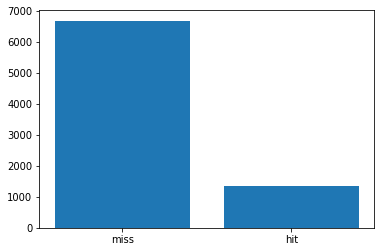

In [7]:
# what's the challenge in predicting 
plt.bar(['miss', 'hit'], model_df['HitorMiss'].value_counts())
plt.show()

---
# Train


## We will use SageMaker built-in XGBoost algorithm.

Our data is now ready to be used to train a XGBoost model. Need to define the algorithm, resource need for training along with location of test and validation data. Where to store the output. 
The XGBoost algorithm has many tunable hyperparameters. 

- `max_depth`: Maximum depth of a tree. As a cautionary note, a value too small could underfit the data, while increasing it will make the model more complex and thus more likely to overfit the data (in other words, the classic bias-variance tradeoff).
- `eta`: Step size shrinkage used in updates to prevent overfitting.  
- `eval_metric`: Evaluation metric(s) for validation data. For data sets such as this one with imbalanced classes, we'll use the AUC metric.
- `scale_pos_weight`: Controls the balance of positive and negative weights, again useful for data sets having imbalanced classes.

First we'll setup the parameters for a training job, then create a training job with those parameters and run it. 

In [8]:
job_name = 'videogames-xgboost-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job name = ", job_name)
#print("my_bucket ="+my_bucket)
      

containers = {
                'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
                'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
                'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
                'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'
             }

create_training_params = \
{
    "RoleArn": role,
    "TrainingJobName": job_name,
    "AlgorithmSpecification": {
        "TrainingImage": containers[boto3.Session().region_name],
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c5.2xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train".format(my_bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "CSV",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation".format(my_bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "CSV",
            "CompressionType": "None"
        }
    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/output".format(my_bucket, prefix)
    },
    "HyperParameters": {
        "max_depth":"3",
        "eta":"0.1",
        "eval_metric":"auc",
        "scale_pos_weight":"2.0",
        "subsample":"0.5",
        "objective":"binary:logistic",
        "num_round":"100"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

Training job name =  videogames-xgboost-2021-11-03-20-16-50


In [9]:
%%time

# this takes around 4 min

sm = boto3.client('sagemaker')
# kick-off the training and pass the params
sm.create_training_job(**create_training_params)

# check when it's done
status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print("training job status = "+status)

try:
    sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status, model saved: " + status)
    if status == 'Failed':
        message = sm.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')

training job status = InProgress
Training job ended with status, model saved: Completed
CPU times: user 107 ms, sys: 11.3 ms, total: 118 ms
Wall time: 4min


---
# Amazon SageMaker inference options
1. Synchronous Infererence
1. Batch Inference


## Real-time
## 1. Amazon SageMaker Hosting Services
Use Hosting Services when you require persistent endpoint - one prediction at a time for real time inference


Now that we've trained the XGBoost algorithm on our data, let's prepare the model for hosting on a SageMaker serverless endpoint.  We will:

1. Point to the scoring container
1. Point to the model.tar.gz that came from training
1. Create the hosting model

In [10]:
create_model_response = sm.create_model(
    ModelName=job_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        'Image': containers[boto3.Session().region_name],
        'ModelDataUrl': sm.describe_training_job(TrainingJobName=job_name)['ModelArtifacts']['S3ModelArtifacts']})

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-1:406078665760:model/videogames-xgboost-2021-11-03-20-16-50


### Next, we'll first configure - an endpoint configuration and then a HTTP endpoint

1. EC2 instance type to use for hosting
1. The initial number of instances
1. Our hosting model name

Let's configure the endpoint configuration first, 

In [11]:
xgboost_endpoint_config = 'videogames-xgboost-endpoint-config-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

print(" Endpoint configuration = "+xgboost_endpoint_config)

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=xgboost_endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.t2.medium',
        'InitialInstanceCount': 1,
        'ModelName': job_name,
        'VariantName': 'AllTraffic'}])

#print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

 Endpoint configuration = videogames-xgboost-endpoint-config-2021-11-03-20-25-41


Then we'll create the endpoint itself.

In [12]:
%%time

# this can take around 6 mins

xgboost_endpoint = 'videogames-xgb-endpoint-' + strftime("%Y%m%d%H%M", gmtime())
print("xgboost_endpoint = "+xgboost_endpoint)

create_endpoint_response = sm.create_endpoint(
    EndpointName=xgboost_endpoint,
    EndpointConfigName=xgboost_endpoint_config)

print(" endpoint response = "+create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp['EndpointStatus']
print("Endpoint creation Status 1: " + status)

try:
    sm.get_waiter('endpoint_in_service').wait(EndpointName=xgboost_endpoint)
finally:
    resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Endpoint creation Status 2: " + status)

    if status != 'InService':
        message = sm.describe_endpoint(EndpointName=xgboost_endpoint)['FailureReason']
        print('Endpoint creation failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

xgboost_endpoint = videogames-xgb-endpoint-202111032026
 create endpoint response = arn:aws:sagemaker:us-east-1:406078665760:endpoint/videogames-xgb-endpoint-202111032026
Endpoint creation Status 1: Creating
Arn: arn:aws:sagemaker:us-east-1:406078665760:endpoint/videogames-xgb-endpoint-202111032026
Endpoint creation Status 2: InService
CPU times: user 159 ms, sys: 14.3 ms, total: 173 ms
Wall time: 6min 4s


In [13]:
runtime = boto3.client('runtime.sagemaker')

In [14]:
# just extract the feature columns by dropping the label so we can use it for testing
test_df = pd.read_csv('s3://'+my_bucket+'/'+prefix+'/test/test_data.csv')
test_file0 = "test_data.csv"
test_df.to_csv(test_file0, index=False)

test_features_df = test_df.drop(test_df.columns[[0]], axis=1)
#t upload and save the features csv file
session = sagemaker.Session()
test_file = "test_features.csv"
test_features_df.to_csv(test_file, index=False)

#test_s3_path = boto3.Session().resource('s3').Bucket(bucket).Object(prefix + '/data/test.csv').upload_file('test.csv')

test_s3_path = session.upload_data(bucket=my_bucket, path=test_file, key_prefix="{}/data".format(prefix))
test_s3_path

's3://2021-10-train-deploy-model-vilas2/sagemaker/videogames_xgboost/data/test_features.csv'

In [15]:
# just test in prediction
#s3_client = boto3.client('s3')
#s3_client.download_file(bucket, prefix+'/test/test_data.csv', './test_data.csv')

#test_data = 's3://2021-10-train-deploy-xgboost-rf/sagemaker/videogames_xgboost/test/test_data.csv'
with open('test_features.csv', 'r') as f:
    for i in range(3,5):
        single_test = f.readline()
        response = runtime.invoke_endpoint(EndpointName = xgboost_endpoint,
                                                  ContentType = 'text/csv',
                                                  Body = single_test)
        result = response['Body'].read().decode('ascii')
        print('Predicted label is {}.'.format(result))

Predicted label is 0.31712886691093445.
Predicted label is 0.42936569452285767.


---

# Evaluation

Now that we have our hosted endpoint, we can generate predictions from it. More specifically, let's generate predictions from our test data set to understand how well our model generalizes to data it has not seen yet.

There are many ways to compare the performance of a machine learning model.  We'll start simply by comparing actual to predicted values of whether the game was a "hit" (`1`) or not (`0`).  Then we'll produce a  confusion matrix, which shows how many test data points were predicted by the model in each category versus how many test data points actually belonged in each category.

In [22]:
# evaluation 
#model_df = pd.read_csv('s3://'+my_bucket+'/'+prefix+'/dataset/model_data.csv')
batch_data = pd.read_csv('s3://'+my_bucket+'/'+prefix+'/data/test_hdr_data.csv')
batch_data


,HitorMiss,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Publisher_bitComposer Games,Publisher_id Software,Publisher_inXile Entertainment,Rating_AO,Rating_E,Rating_E10+,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,0,75.0,6.4,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,59.0,7.3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,66.0,6.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,64.0,6.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,65.0,8.7,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5609,1,83.0,8.3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5610,1,82.0,7.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5611,0,71.0,7.1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5612,0,41.0,4.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


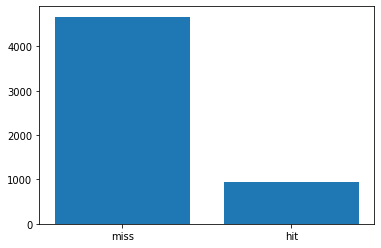

In [23]:
# what's the cto show output distribution
plt.bar(['miss', 'hit'], batch_data['HitorMiss'].value_counts())
plt.show()

In [24]:
### this needs to be replaced by csv file input
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    #print("result = "+str(result))
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

# ----------------------------
def bulk_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    print(" items = "+str(items))
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            #print(" result = "+str(results))
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [25]:
%%time
import json


with open('test_data.csv', 'r') as f:
    payload = f.read().strip()
    #print(" payload = "+str(payload))
    
labels = [int(line.split(',')[0]) for line in payload.split('\n')]

with open('test_features.csv', 'r') as f2:
     payload2 = f2.read().strip()


test_data = [line for line in payload2.split('\n')]
#test_data
#test_data = test_df.drop(test_df.columns[[0]], axis=1)
#test_data.shape
#print("test_data = "+str(test_data))
# do the prediction
preds = bulk_predict(test_data, 100, xgboost_endpoint, 'text/csv')
#print("preds = "+str(preds))
print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

 items = 803
.........
error rate=0.135741
CPU times: user 39.3 ms, sys: 7.42 ms, total: 46.7 ms
Wall time: 420 ms


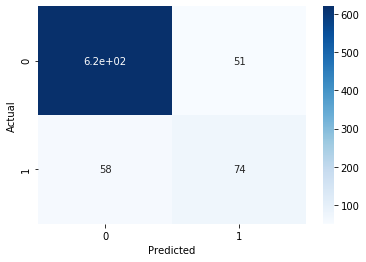

In [26]:
#import pandas as pd
#import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    np.array(labels),
        'y_Predicted': np.array(preds)
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.show()

Of the all games in the test set that actually are "hits" by our metric, the model correctly identified 74, while the overall error rate is 13%.  The amount of false negatives versus true positives can be shifted substantially in favor of true positives by increasing the hyperparameter scale_pos_weight. Of course, this increase comes at the expense of reduced accuracy/increased error rate and more false positives. How to make this trade-off ultimately is a business decision based on the relative costs of false positives, false negatives, etc.

---
# Batch
## 2. Batch Inference - Amazon SageMaker Batch Transform

Use Batch Transform when you need prediction for an entire dataset - one after another

For this, we need to specify:
- Hardware specification (instance count and type).  Prediction is embarassingly parallel, so feel free to test this with multiple instances, but since our dataset is not enormous, we'll stick to one.
- `strategy`: Which determines how records should be batched into each prediction request within the batch transform job.  'MultiRecord' may be faster, but some use cases may require 'SingleRecord'.
- `output_path`: The S3 location for batch transform to be output.  Note, file(s) will be named with '.out' suffixed to the input file(s) names.  In our case this will be 'train.csv.out'.  Note that in this case, multiple batch transform runs will overwrite existing values unless this is updated appropriately.


In [27]:
# another option need to know what algo is here
from sagemaker.transformer import Transformer
output_path = f"s3://{my_bucket}/{prefix}/output/"

transformer = Transformer(model_name=job_name,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    strategy="MultiRecord",
    max_payload=6,
    max_concurrent_transforms=1,
    output_path=output_path,
)

transformer.transform(test_s3_path, content_type="text/csv", split_type="Line")
transformer.wait()

....................................
Arguments: serve
Arguments: serve
[2021-11-03 20:51:57 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-11-03 20:51:57 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-11-03 20:51:57 +0000] [1] [INFO] Using worker: gevent
[2021-11-03 20:51:57 +0000] [20] [INFO] Booting worker with pid: 20
[2021-11-03 20:51:57 +0000] [21] [INFO] Booting worker with pid: 21
[2021-11-03 20:51:57 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/

Now that our batch transform job has completed, let's take a look at the output. 

In [ ]:
!aws s3 cp "s3://{my_bucket}/{prefix}/output/test_features.csv.out" ./

In [ ]:
!head ./test_features.csv.out

---
## CleanUp

This XGBoost model is just the starting point for predicting whether a game will be a hit based on reviews and other features.  There are several possible avenues for improving the model's performance.  First, of course, would be to collect more data and, if possible, fill in the existing missing fields with actual information.  Another possibility is further hyperparameter tuning, with Amazon SageMaker's Hyperparameter Optimization service.  And, although ensemble learners often do well with imbalanced data sets, it could be worth exploring techniques for mitigating imbalances such as downsampling, synthetic data augmentation, and other approaches.  

In [ ]:
sm.delete_endpoint(EndpointName=xgboost_endpoint)